# Testing out the reparameterization trick

Just a simple implementation to test if it will be appropriate for the GLM, if it is, we can use Auto-Encoding Variational Bayes inference.

The basic premise is we can construct a differenctiable Monte-Carlo estimator,
$$
    \mathbb{E}_{q(z)}[f(z)] = \int q_{\theta}(z|x) f(z) dz
        \approx \frac{1}{L} \sum^L_{l=1} f(g_{\theta}(x, \epsilon^{(l)})),
$$
where
$$
    z^{(l)} = g_{\theta}(x, \epsilon^{(l)}) \qquad \text{and} \qquad \epsilon^{(l)} \sim p(\epsilon),
$$
that results in lower variance derivatives than Monte-Carlo sampling the derivatives using, e.g. variational black box methods.

## Test 1: $f(z)$ is a log-Normal

### Likelihood approximation

Let's start with a really simple example,
$$
\begin{align}
    f(z) &= \log \mathcal{N}(x|z, \sigma^2), \\
    q_\theta(z | x) &= \mathcal{N}(z | \mu, \lambda).
\end{align}
$$
We can solve this integral analytically,
$$
    \int \mathcal{N}(z | \mu, \lambda) \log \mathcal{N}(x|z, \sigma^2) dz
        = \log \mathcal{N}(x | \mu, \sigma^2) - \frac{\lambda}{2 \sigma^2}
$$
So we can test how this compares to the reparameterization trick results.
lets use the following deterministic function for reparameterization,
$$
    g_{(\mu, \lambda)}(\epsilon^{(l)}) = \mu + \sqrt{\lambda}\epsilon^{(l)}
$$
where
$$
    p(\epsilon) = \mathcal{N}(0, 1)
$$
Now let's test:
$$
    \log \mathcal{N}(x | \mu, \sigma^2) - \frac{\lambda}{2 \sigma^2} \stackrel{?}{\approx}
    \frac{1}{L} \sum^L_{l=1} \log \mathcal{N}(x|,g_{(\mu, \lambda)}(\epsilon^{(l)}), \sigma^2)
$$

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl
pl.style.use('ggplot')

from scipy.stats import norm
from scipy.special import expit
from scipy.integrate import quadrature
from scipy.misc import derivative

from revrand.mathfun.special import softplus
from revrand.optimize import sgd, Adam


In [10]:
# Initial values
x = 0
mu = 2
sigma = 3
lambd = 0.5
L = 50


In [11]:
# The test
exact = norm.logpdf(x, loc=mu, scale=sigma) - lambd / (2 * sigma**2)
print("Exact expectation = {}".format(exact))

# Normal Monte Calo estimation
z = norm.rvs(loc=mu, scale=np.sqrt(lambd), size=(L,))
approx_mc = norm.logpdf(x, loc=z, scale=sigma)
print("MC Approx expectation = {} ({})".format(approx_mc.mean(), approx_mc.std()))

# Reparameterised Sampling
g = lambda e: mu + np.sqrt(lambd) * e
e = norm.rvs(loc=0, scale=1, size=(L,))
approx_re = norm.logpdf(x, loc=g(e), scale=sigma)
    
print("Reparameterized Approx expectation = {} ({})".format(approx_re.mean(), approx_re.std()))


Exact expectation = -2.2675508218727822
MC Approx expectation = -2.2454985478550866 (0.17497065779262636)
Reparameterized Approx expectation = -2.2638667063334306 (0.1363414158212594)


We would expect a trivial relationship here between exact monte-carlo and the reparameterization trick, since they are doing the same thing. Lets see if gradient estimates have lower variances now.


### Gradient approximation
Let's evaluate the exact gradient for $\mu$,
$$
    \frac{\partial}{\partial \mu} \left(\log \mathcal{N}(x | \mu, \sigma^2) - \frac{\lambda}{2 \sigma^2} \right) = 
        \frac{1}{\sigma^2} (x - \mu)
$$
Now the approximation
$$
\begin{align}
    \frac{\partial}{\partial \mu} \left(
        \frac{1}{L} \sum^L_{l=1} \log \mathcal{N}(x|,g_{(\mu, \lambda)}(\epsilon^{(l)}), \sigma^2) \right) &=
        \frac{1}{L} \sum^L_{l=1} \frac{1}{\sigma^2} (x - g_{(\mu, \lambda)}(\epsilon^{(l)}))
        \frac{\partial g_{(\mu, \lambda)}(\epsilon^{(l)})}{\partial \mu}, \\
        &= \frac{1}{L} \sum^L_{l=1} \frac{1}{\sigma^2} (x - g_{(\mu, \lambda)}(\epsilon^{(l)})).
\end{align}
$$

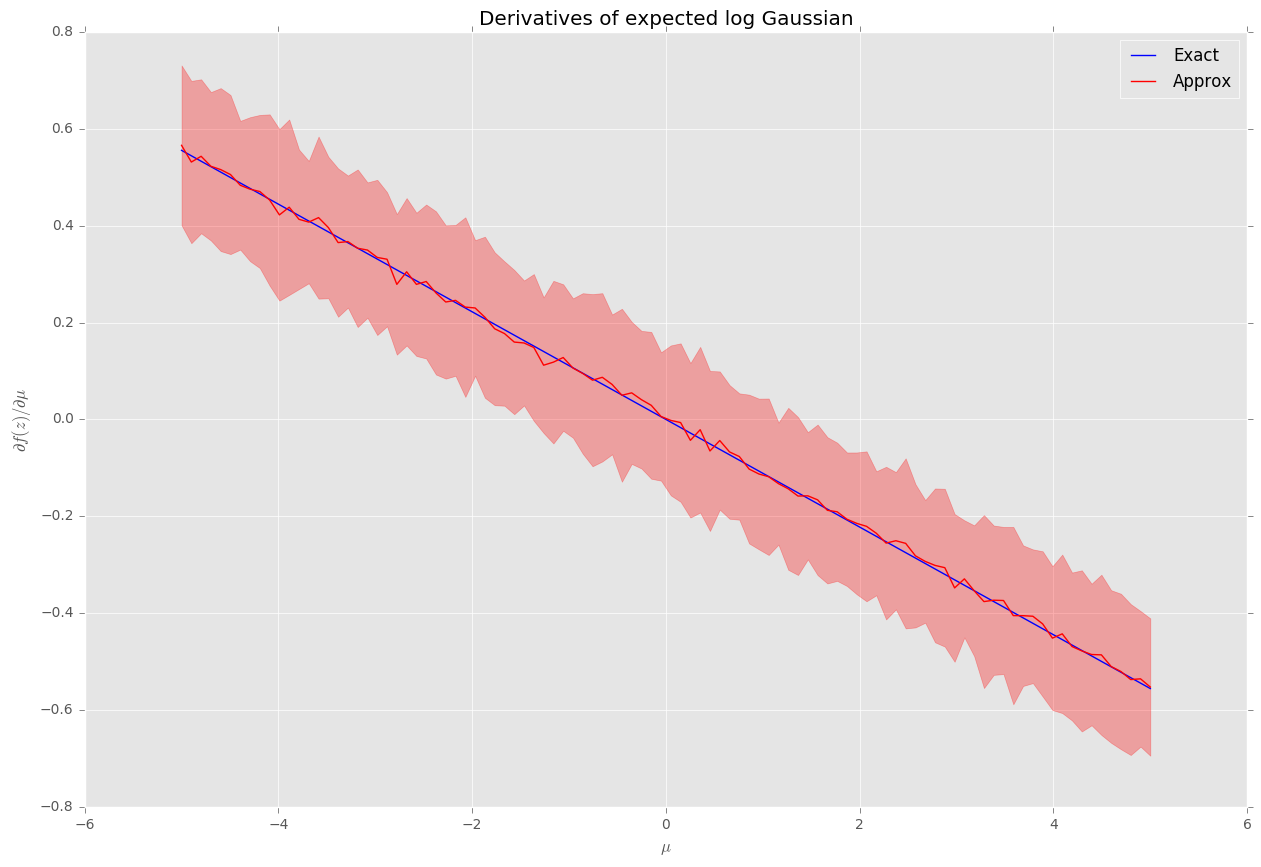

In [12]:
# A range of mu's
N = 100
mu = np.linspace(-5, 5, N)

# Exact
dmu = (x - mu) / sigma**2

# Approx
e = norm.rvs(loc=0, scale=1, size=(L, N))
approx_dmu = (x - g(e)) / sigma**2
Edmu = approx_dmu.mean(axis=0)
Sdmu = approx_dmu.std(axis=0)

# plot
pl.figure(figsize=(15, 10))
pl.plot(mu, dmu, 'b', label='Exact')
pl.plot(mu, Edmu, 'r', label= 'Approx')
pl.fill_between(mu, Edmu - 2 * Sdmu, Edmu + 2 * Sdmu, edgecolor='none', color='r', alpha=0.3)
pl.legend()
pl.title("Derivatives of expected log Gaussian")
pl.xlabel('$\mu$')
pl.ylabel('$\partial f(z)/ \partial \mu$')
pl.show()


## Test 2: $f(z)$ is log Bernoulli

Now let's try the following function with the same posterior and $g$ as before,

$$
    f(z) = \log \text{Bern}(x | \text{logistic}(z)) = x z - \log(1 + exp(z))
$$

We can get an "exact" expectation using quadrature. First of all, likelihoods,

### Likelihood Approximation

In [13]:
# Quadrature
def qlogp(z, mu):
    
    q = norm.pdf(z, loc=mu, scale=np.sqrt(lambd))
    logp = x * z - softplus(z)
    return q * logp

def quadELL(mu):
    return quadrature(qlogp, a=-10, b=10, args=(mu,))[0]

ELL = [quadELL(m) for m in mu]

# Reparam
e = norm.rvs(loc=0, scale=1, size=(L, N))
approx_ELL = x * g(e) - softplus(g(e))
EELL = approx_ELL.mean(axis=0)
SELL = approx_ELL.std(axis=0)



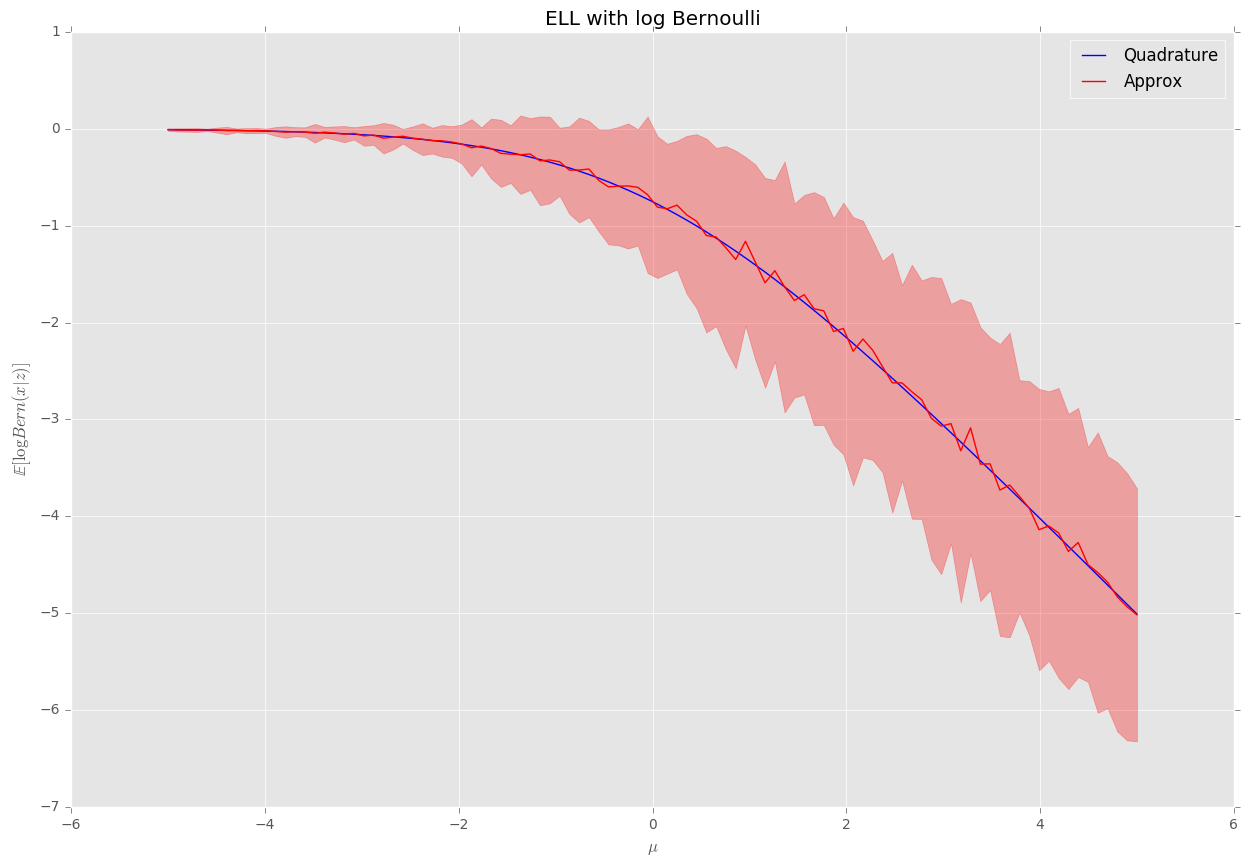

In [14]:
# plot
pl.figure(figsize=(15, 10))
pl.plot(mu, ELL, 'b', label='Quadrature')
pl.plot(mu, EELL, 'r', label= 'Approx')
pl.fill_between(mu, EELL - 2 * SELL, EELL + 2 * SELL, edgecolor='none', color='r', alpha=0.3)
pl.legend()
pl.title("ELL with log Bernoulli")
pl.xlabel('$\mu$')
pl.ylabel('$\mathbb{E}[\log Bern(x | z)]$')
pl.show()


### Gradient approximation

$$
\begin{align}
    \frac{\partial}{\partial \mu} \mathbb{E}_q \left[\frac{\partial f(z)}{\partial \mu} \right]
    &\approx \frac{1}{L} \sum^L_{l=1} (x - \text{logistic}(g(\epsilon^{(l)})))
        \frac{\partial g(\epsilon^{(l)})}{\partial \mu} \\
    &= \frac{1}{L} \sum^L_{l=1} x - \text{logistic}(g(\epsilon^{(l)}))
\end{align}
$$

In [15]:
# Quadrature
dmu = [derivative(quadELL, m) for m in mu]

# Reparam
e = norm.rvs(loc=0, scale=1, size=(L, N))
approx_dmu = x - expit(g(e))
Edmu = approx_dmu.mean(axis=0)
Sdmu = approx_dmu.std(axis=0)


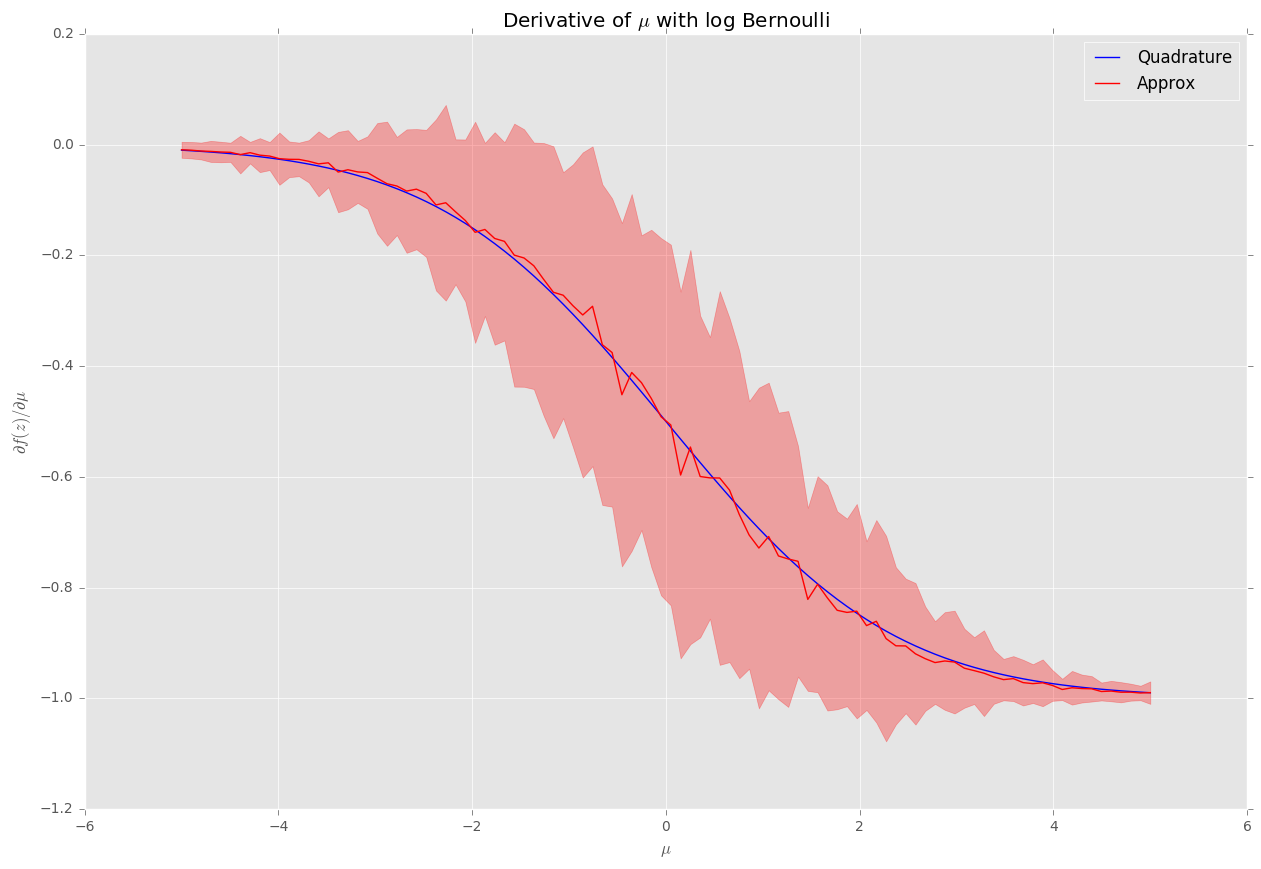

In [16]:
# plot
pl.figure(figsize=(15, 10))
pl.plot(mu, dmu, 'b', label='Quadrature')
pl.plot(mu, Edmu, 'r', label= 'Approx')
pl.fill_between(mu, Edmu - 2 * Sdmu, Edmu + 2 * Sdmu, edgecolor='none', color='r', alpha=0.3)
pl.legend()
pl.title("Derivative of $\mu$ with log Bernoulli")
pl.xlabel('$\mu$')
pl.ylabel('$\partial f(z)/ \partial \mu$')
pl.show()


## Optimisation test

Now let's see if we can optimise Expected log likelihood using SG!


In [18]:
data = np.ones((100, 1), dtype=bool)
mu_rec, dmu_rec = [], []

def ell_obj(mu, x, samples=100):
    e = norm.rvs(loc=0, scale=1, size=(samples,))
    g = mu + np.sqrt(lambd) * e
    
    ll = (x * g - softplus(g)).mean()
    dmu = (x - expit(g)).mean()
    
    mu_rec.append(float(mu))
    dmu_rec.append(float(dmu))
    
    return -ll, -dmu
    
res = sgd(ell_obj, x0=np.array([-4]), data=data, maxiter=1000, updater=Adam(), eval_obj=True)
    

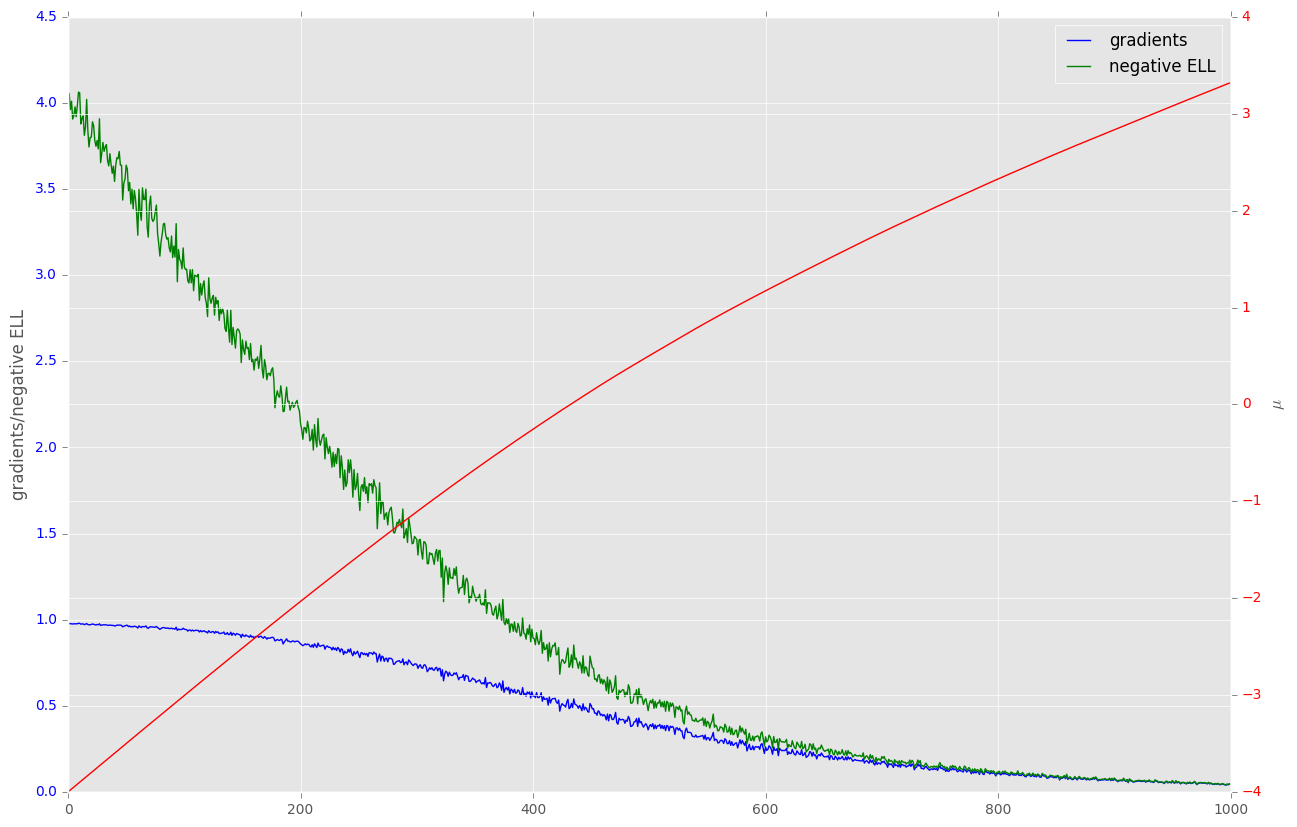

In [19]:
# plot
niter = len(mu_rec)

fig = pl.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)

ax1.plot(range(niter), res.norms, 'b', label='gradients')
ax1.plot(range(niter), res.objs, 'g', label='negative ELL')
ax1.set_ylabel('gradients/negative ELL')
ax1.legend()
for t in ax1.get_yticklabels():
    t.set_color('b')
    
ax2 = ax1.twinx()
ax2.set_ylabel('$\mu$')
ax2.plot(range(niter), mu_rec, 'r', label='$\mu$')
for t in ax2.get_yticklabels():
    t.set_color('r')
    
pl.show()
